# Solving Diffution Equation with SA-PINN

## Problem Setup
Diffusion Equation: 

$$u_t = u_xx - e^{-t}(\sin(\pi x) - \pi^2\sin(\pi x)) \quad x \in [-1, 1], t\in [0, 1]$$

Initial Condition: $$u(x, 0) = \sin(\pi x)$$
Boudary Conditions: $$u(-1, t) = u(1, t) = 0$$
Exact solution: $$u(x, t) = e^{-t}\sin(\pi x)$$


## Install and Import Libraries

In [3]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=51a195fe5b6dc6fb7e2060840460d6f6205a9b730713fe7a7c1b71ad25f4c3d9
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [4]:
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from pyDOE import lhs
import tensorflow as tf
import numpy as np
import scipy.optimize
import scipy.io

np.random.seed(1234)
tf.random.set_seed(1234)

### Check GPU Status

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Mar  4 07:50:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11802280120051195330
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14385217536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6455140676743085347
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Generate Dataset

In [33]:
def exact_solution(dataset):
    x = dataset[:, 0]
    t = dataset[:, 1]
    return np.exp(-t) * np.sin(np.pi * x)

In [34]:
xmin = -1.0
xmax = 1.0
tmin = 0
tmax = 1.0

## test set: 101 x 101 uniform grid
x_test = np.linspace(xmin, xmax, 101)
t_test = np.linspace(tmin, tmax, 101)
X, T = np.meshgrid(x_test, t_test)
X_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
# exact solution
u_e = exact_solution(X_u_test)[:, None] # shape: 10201 x 1

lb = X_u_test[0]
ub = X_u_test[-1]

## training set

# training data for initial condition
ic_point_count = 100

b_x = xmin + (xmax - xmin) * np.random.rand(ic_point_count, 1)
X_train_IC = np.hstack((b_x, np.zeros_like(b_x)))
u_train_IC = np.sin(np.pi * X_train_IC[:, 0])[:, None]

# training data for boundary conditions
bc_point_count_each = 100

b_t = tmin + (tmax - tmin) * np.random.rand(bc_point_count_each, 1)
X_train_BC_bottom = np.hstack((np.ones_like(b_t) * xmin, b_t))
u_train_BC_bottom = np.zeros_like(b_t)

X_train_BC_top = np.hstack((np.ones_like(b_t) * xmax, b_t))
u_train_BC_top = np.zeros_like(b_t)

N_u = 100 + 2 * 100
X_u_train = np.vstack([X_train_IC, X_train_BC_bottom, X_train_BC_top])
u_train = np.vstack([u_train_IC, u_train_BC_bottom, u_train_BC_top])

# training set for the PDE
N_f = 8000

# Latin Hypercube sampling for the collocation points
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train)) # 把边界点也加进pde的训练集中

## Define SA-PINN Model

In [42]:
class SAPINN(tf.Module):
    """
    Define a SA-PINN for approximation the solution of burgers equation.

    Params:
      layers: an array of each layer's width(num of neurons)
      lb: [xmin, tmin],
      ub: [xmax, tmax]
    """
    def __init__(self, layers, lb, ub):
        self.weights = [] # list of model's parameters(weights and bias)
        self.parameters_num = 0 # numbers of model's parameters
        self.layers = layers
        self.lb = lb
        self.ub = ub
        self.epoch = 0 

        # setup model weights
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]

            std = np.sqrt(2 / (input_dim + output_dim))

            w_value = tf.random.normal([input_dim, output_dim], stddev=std, dtype='float64')
            w = tf.Variable(w_value, trainable=True, name=f'w{i+1}')
            self.weights.append(w)

            b_value = tf.zeros([output_dim, ], dtype='float64')
            b = tf.Variable(b_value, trainable=True, name=f'b{i+1}')
            self.weights.append(b)

            # num += num_of_weight + num_of_bias
            self.parameters_num += input_dim * output_dim + output_dim
    
        # self-adaptive weights

        ## boundary weights
        self.u_weights = tf.Variable(tf.ones([N_u, 1], dtype="float64"), trainable=True, name='boundary_weight')

        ## residual weights
        self.f_weights = tf.Variable(tf.ones([N_f+N_u, 1], dtype='float64'), trainable=True, name='pde_weight')

    def __call__(self, X):
        """
        Define forward pass, i.e. use model to predict the result

        Params:
          X: the dataset, that will be used to predict
        """
        x = X
        x = (x - self.lb) / (self.ub - self.lb)

        # applying activation function
        for i in range(len(self.layers)-2):
            # x = activation_function(wx + b)
            x = tf.nn.tanh(tf.add(tf.matmul(x, self.weights[2*i]), self.weights[2*i+1]))

        # output layer(without activation function)
        x = tf.add(tf.matmul(x, self.weights[-2]), self.weights[-1])
        return x

    def loss_BC_IC(self, X_u_train, u_train):
        """
        Calculate the loss score of boundary condition and initial condition

        Params:
          X_u_train: training set of boundary condition and initial condition
          u_train: exact `u` value at the BC/IC training set (since we have the data of `u`, we can use part of it to train model)
        """

        # element-wise multiply by adaptive weights of boundary
        loss_u = self.u_weights * (u_train - self(X_u_train))
        loss_u = tf.reduce_mean(tf.square(loss_u))
        return loss_u

    def loss_PDE(self, X_f_train):
        """
        Calculate the loss score of PDE

        Params: 
          X_f_train: trainning set of PDE as well as BC/IC (I've concatenated them above)
        """
    
        X = tf.Variable(X_f_train, dtype = 'float64', trainable=False)

        x_f = X[:, 0:1]
        t_f = X[:, 1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            # tf.stack([x_f[:, 0], t_f[:, 0]], axis=1) <=> X
            # It's been destructured then stacked because we need the gradients of x and t
            X = tf.stack([x_f[:, 0], t_f[:, 0]], axis=1)   

            u = self(X)
            u_x = tape.gradient(u, x_f)

        u_t = tape.gradient(u, t_f)    
        u_xx = tape.gradient(u_x, x_f)

        del tape

        # f: residual of pde
        f = u_t - u_xx + tf.exp(-t_f) * (tf.sin(np.pi * x_f) - np.pi**2 * tf.sin(np.pi * x_f))

        # element-wise multiply by adaptive weights of residual
        loss_f = tf.reduce_mean(tf.square(self.f_weights * f))

        return loss_f

    def loss(self, X_u_train, u_train, X_f_train):

        """
        Calculate total loss of the model

        Params:
          X_u_train: training set of boundary condition and initial condition
          u_train: exact `u` value at the BC/IC training set
          X_f_train: trainning set of PDE as well as BC/IC
        """

        loss_u = self.loss_BC_IC(self.X_u_train, self.u_train)
        loss_f = self.loss_PDE(self.X_f_train)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f

    def set_training_set(self, X_u_train, u_train, X_f_train):
        """
        set training set for the model.

        X_u_train: training set of boundary condition and initial condition
        u_train: exact `u` value at the BC/IC training set
        X_f_train: trainning set of PDE as well as BC/IC
        """
        
        self.X_u_train = X_u_train
        self.u_train = u_train
        self.X_f_train = X_f_train

    def get_weights(self):
        """
        Return a 'long' tensor of model weights' current value
        """

        long_weights_tensor = []

        for i in range(len(self.layers)-1):
            # flatten weights and biases
            w_1d = tf.reshape(self.weights[2*i], [-1]) 
            b_1d = tf.reshape(self.weights[2*i+1], [-1])

            # then concatenate them into a single tensor
            long_weights_tensor = tf.concat([long_weights_tensor, w_1d], axis=0)
            long_weights_tensor = tf.concat([long_weights_tensor, b_1d], axis=0)

        return long_weights_tensor

    def set_weights(self, parameters):
        """
        Set model weights, given new weights values(stored in parameters)

        Params:
          parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in self.get_weights()
        """

        # Since `parameters` is a long tensor, we have to destructure it to update model weights.
        # To do that, we need shape and size of each weight and bias

        for i in range(len(self.layers)-1):
            w_shape = tf.shape(self.weights[2*i]).numpy()
            w_size = tf.size(self.weights[2*i]).numpy()

            # pick new weight in `parameters`
            new_w = parameters[0:w_size]
            self.weights[2*i].assign(tf.reshape(new_w, w_shape))
            parameters = np.delete(parameters, np.arange(w_size), axis=0) # delete this part from `parameters`, so we can get next bias from index 0

            b_shape = tf.shape(self.weights[2*i+1]).numpy()
            b_size = tf.size(self.weights[2*i+1]).numpy()

             # pick new bias in `parameters`
            new_b = parameters[0:b_size]
            self.weights[2*i+1].assign(tf.reshape(new_b, b_shape))
            parameters = np.delete(parameters, np.arange(b_size), axis=0) # delete this part from `parameters`, so we can get next weight from index 0

    def optimizer_func(self, parameters):
        """
        Define an optimizer function for scipy's l-bfgs optimizer

        Params:
          parameters: a "long" tensor of new model weights, whose size and shape fit `long_weights_tensor` defined in self.get_weights()

        Returns:
          loss.numpy(): loss score of the model
          gradients_1d.numpy(): a numpy array of gradients
        """

        self.set_weights(parameters) # set new weights

        with tf.GradientTape() as tape:
            tape.watch(self.weights)
            
            # loss after update
            loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        gradients = tape.gradient(loss, self.weights)

        del tape

        gradients_1d = [] # flatten gradients, like `long_weights_tensor` defined in self.get_weights()

        for i in range(len(self.layers)-1):
            # flatten gradients of weights and biases
            gradients_w_1d = tf.reshape(gradients[2*i], [-1]) 
            gradients_b_1d = tf.reshape(gradients[2*i+1], [-1])

            # then concatenate them into a single tensor
            gradients_1d = tf.concat([gradients_1d, gradients_w_1d], 0) 
            gradients_1d = tf.concat([gradients_1d, gradients_b_1d], 0)

        return loss.numpy(), gradients_1d.numpy()

    def optimizer_callback(self, parameters):
        """
        Define an optimizer callback function
        """

        loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        # calculate L2 error at this epoch
        u_pred = self(X_u_test).numpy()
        L2_error = np.linalg.norm((u_e - u_pred), 2) / np.linalg.norm(u_e, 2)

        # print loss, loss_u, loss_f, L2_error at this epoch
        self.epoch += 1
        tf.print(f"epoch: {self.epoch} loss:{loss:.5f} loss_u: {loss_u:.5f} loss_f: {loss_f:.5f} L2_error: {L2_error:.5f}")

    def adaptive_gradients(self):
        """
        Calculate model weights' gradients, as well as adaptive weights' gradients
        """

        with tf.GradientTape() as tape:
            tape.watch(self.weights)

            loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        # gradients of model' weights
        gradients = tape.gradient(loss, self.weights)

        del tape

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.u_weights)
            tape.watch(self.f_weights)

            loss, loss_u, loss_f = self.loss(self.X_u_train, self.u_train, self.X_f_train)

        # gradients of adaptive weiths
        gradient_u_weights = tape.gradient(loss, self.u_weights)
        gradient_f_weights = tape.gradient(loss, self.f_weights)

        del tape

        return loss, gradients, gradient_u_weights, gradient_f_weights

## Load Model

Load model from previously saved model. (See **Save Model below**)

In [ ]:
import json

def load_model(model_path):
    """
    return an trained SA-PINN model for burgers equation
    
    params:
      model_path: path of json file that contains model's data
    """
    
    with open(model_path, 'r') as f:
        model_data = json.load(f)
        f.close()
    
    # data
    layers = np.array(model_data['layers'])
    model_weights = np.array(model_data['model_weights'])
    model_adaptive_weights = model_data['model_adaptive_weights']

    model =  SAPINN(layers, lb, ub) # SAPINN, lb, ub must be defined before you load the model
    model.set_training_set(X_u_train, X_f_train) # X_u_train, X_f_train must be defined before you load the model
    model.set_weights(model_weights)
    model.u_weights.assign(np.array(model_adaptive_weights[0]))
    model.f_weights.assign(np.array(model_adaptive_weights[1]))
    
    return model

In [ ]:
model_path = 'models/SAPINNmodel.json' # your model path

sa_pinn = load_model(model_path)

## Train the Model

In [44]:
layers = np.array([2, 32, 64, 32, 1])
sa_pinn = SAPINN(layers, lb, ub)
sa_pinn.set_training_set(X_u_train, u_train, X_f_train)

# firstly, use Tensorflow Adam optimizer to apply gradient descent/ascent
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer_u_weight = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
optimizer_f_weight = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

adam_epochs = 5000
print("Starting Adam training")
for epoch in range(adam_epochs):

    loss, gradients, gradient_u_weights, gradient_f_weights = sa_pinn.adaptive_gradients()


    print(f"epoch: {epoch+1} loss: {loss.numpy():.5f}")

    # apply gradient descent on model weights
    optimizer.apply_gradients(zip(gradients, sa_pinn.weights))
    # apply gradient ascent on adaptive weights
    optimizer_u_weight.apply_gradients(zip([-gradient_u_weights], [sa_pinn.u_weights]))
    optimizer_f_weight.apply_gradients(zip([-gradient_f_weights], [sa_pinn.f_weights]))

# then, use scipy l-bfgs optimizer to train model
lbfgs_epochs = 5000
print("Starting L-BFGS training")
options = {
    'disp': None,
    'maxcor': 200, 
    'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
    'gtol': 5e-8, 
    'maxfun':  50000, 
    'maxiter': lbfgs_epochs,
    'iprint': -1,   #print update every 50 iterations
    'maxls': 50}

results = scipy.optimize.minimize(
    fun=sa_pinn.optimizer_func,
    x0=sa_pinn.get_weights().numpy(),
    args=(),
    method='L-BFGS-B',
    jac=True,
    callback=sa_pinn.optimizer_callback,
    options=options
)

Streaming output truncated to the last 5000 lines.
epoch: 1 loss:0.00017 loss_u: 0.00003 loss_f: 0.00014 L2_error: 0.00392
epoch: 2 loss:0.00016 loss_u: 0.00003 loss_f: 0.00014 L2_error: 0.00387
epoch: 3 loss:0.00015 loss_u: 0.00003 loss_f: 0.00013 L2_error: 0.00362
epoch: 4 loss:0.00015 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00359
epoch: 5 loss:0.00015 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00351
epoch: 6 loss:0.00015 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00349
epoch: 7 loss:0.00015 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00351
epoch: 8 loss:0.00015 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00357
epoch: 9 loss:0.00015 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00359
epoch: 10 loss:0.00014 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00359
epoch: 11 loss:0.00014 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00355
epoch: 12 loss:0.00014 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00355
epoch: 13 loss:0.00014 loss_u: 0.00003 loss_f: 0.00012 L2_error: 0.00354
epoch: 14

## Print and Plot the Result

In [45]:
print(results)
sa_pinn.set_weights(results.x)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 1.1133837252229821e-07
        x: [ 4.009e-01  1.931e-01 ... -1.485e-01  2.360e-02]
      nit: 5000
      jac: [ 8.165e-06  1.477e-05 ...  2.661e-06  1.947e-06]
     nfev: 5396
     njev: 5396
 hess_inv: <4321x4321 LbfgsInvHessProduct with dtype=float64>


In [47]:
# L2 error of the model
u_pred = sa_pinn(X_u_test).numpy()
L2_error = np.linalg.norm((u_e - u_pred), 2) / np.linalg.norm(u_e, 2)
print(f'Test set L2 error: {L2_error:5f}')

# loss score of the model
loss, loss_f, loss_u = sa_pinn.loss(X_u_train, u_train, X_f_train)
print(f"loss:{loss} loss_u: {loss_u} loss_f: {loss_f}")

Test set L2 error: 0.000080
loss:1.1133837252229821e-07 loss_u: 1.0441228774891264e-07 loss_f: 6.926084773385563e-09


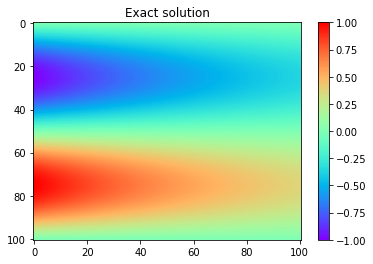

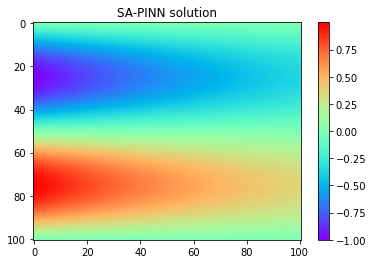

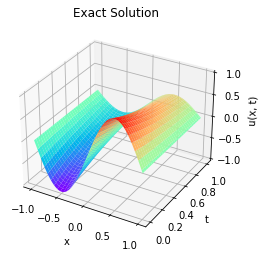

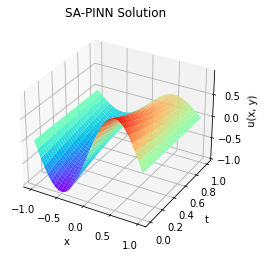

In [48]:
# plot

u_e_for_plot = np.reshape(u_e, (t_test.shape[0], x_test.shape[0]))
u_e_for_plot = np.transpose(u_e_for_plot)

plt.imshow(u_e_for_plot, cmap='rainbow', aspect='auto')
plt.colorbar()
plt.title('Exact solution')
plt.show()
plt.close()

u_pred_for_plot = np.reshape(u_pred, (t_test.shape[0], x_test.shape[0]))
u_pred_for_plot = np.transpose(u_pred_for_plot)
plt.imshow(u_pred_for_plot, cmap='rainbow', aspect='auto')
plt.colorbar()
plt.title('SA-PINN solution')
plt.show()
plt.close()

ax = plt.axes(projection='3d')
ax.plot_surface(X, T, u_e_for_plot.T, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, t)')
ax.set_title('Exact Solution')
plt.show()

ax = plt.axes(projection='3d')
ax.plot_surface(X, T, u_pred_for_plot.T, cmap='rainbow')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x, y)')
ax.set_title('SA-PINN Solution')
plt.show()

## Save Model

**Important: You have to use the same dataset as the above dataset to import and use this saved model. Other datasets will cause error and will cause inacurate result.**

Data to save:

- model's layers => layers (use layers to initialize model)
- model's weights => sa_pinn.get_weights()  (use SA_PINN.set_weight() to set new model's weights)
- model's adaptive weights => sa_pinn.u_weights, sa_pinn.f_weights

In [49]:
import json

data_dict = {
    "layers": layers.tolist(),
    "model_weights": sa_pinn.get_weights().numpy().tolist(),
    "model_adaptive_weights": [sa_pinn.u_weights.numpy().tolist(), sa_pinn.f_weights.numpy().tolist()]
}

data_json = json.dumps(data_dict, indent=4)

with open('SAPINNmodel.json', 'w') as f:
    f.write(data_json)